# Fundamental Analysis
This notebook uses machine learning to conduct a fundamental analysis of stocks. Specifically, XGBoost is trained on stocks at year $t$ and $t-1$ to predict whether the stock price will increase or decrease at year $t+1$. This problem is cast as a classification problem (vs. regression problem), as it is easier to train. 

In [1]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import fix_yahoo_finance

from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
from forex_python.converter import CurrencyRates
import datetime
import pickle
%matplotlib inline

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


In [2]:
# You can get more stock lists from: http://www.nasdaq.com/screening/industries.aspx  
tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")
tickers.head()

,Symbol,Company
0,A,Agilent Technologies
1,AA,Alcoa Inc
2,AACC,Asset Accep Cap Corp
3,AAI,Airtran Hldgs Inc
4,AAII,Alabama Aircraft Ind In


## Get Data

In [3]:
############################################# Helper Functions #############################################
#############################################                  #############################################
#simple progress bar
def progress_bar(stocks, every=10):
    length = float(len(stocks))
    i=0
    for index, item in stocks.iterrows():
        if i % every == 0:
            print >>sys.stderr, i/length,
        yield item[0], item[1]
        i += 1

#small helper function to get first & last day of the month for get_mean_frac_price_change
def first_and_last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BMS')[0], pd.date_range(date, periods=1, freq='BM')[0]

#collects data from yahoo finance, gets mean fractional price change, averaged over the relevant month
def get_mean_frac_price_change(stock, current_date):
    ds = current_date.split('-')
    # get dates
    first_current, last_current = first_and_last_weekday_of_month(current_date)
    first_future, last_future = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    first_past, last_past = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])-1, ds[1]))
    
    # get mean prices
    mean_current_price = pdr.get_data_yahoo(stock, first_current, last_current)['Close'].mean()
    mean_past_price = pdr.get_data_yahoo(stock, first_past, last_past)['Close'].mean()
    mean_future_price = pdr.get_data_yahoo(stock, first_future, last_future)['Close'].mean()
    
    return mean_future_price/mean_current_price, mean_current_price/mean_past_price, mean_current_price

def clean_data(d):
    #delete annoying repeated columns
    del_columns = ['Year over Year','3-Year Average','5-Year Average',
                   '10-Year Average','Taxes Payable','Long-Term Debt']
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    
    #convert commas to dots in relevant columns
    for c in d.columns:
        try:
            d[c]=d[c].str.replace(',','.')
        except:
            pass
    return d

#convert all currency values into USD
def convert_currency(values, date):
    currencies = ['AED','ARS','AUD','BRL','CAD','CHF','CLP','CNY','COP','CZK',
                  'EUR','GBP','HKD','ILS','INR','JPY','KRW','MXN','OMR','PEN',
                  'PLN','RON','RUB','SEK','THB','TWD','ZAR']
    date = date.split("-")
    year, month = int(date[0]), int(date[1])
    for c in currencies:
        mask = values.index.str.contains(c)
        if np.any(mask):
            cr = CurrencyRates()
            values.loc[values.index[mask]] *= cr.get_rate(c, 'USD', datetime.datetime(year, month, 1))
            values.index = [col.replace(c, 'USD') for col in values.index]
            return values
    return values

In [10]:
############################################# Main Functions #############################################
#############################################                #############################################

#scrape financial data from Morningstar for a given stock, get stock prices for t-1, t, t+1
def get_stock_financials(stock, company, year):
    # pre-load stuff
    path = "csv/fundamentals/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    
    # load or scrape data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = """http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=
                    en-CA&region=USA&order=asc&r=314562"""%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
        
    # ensure that data gathered from Morningstar corresponds to company of interest by
    # validating company name in downloaded financial data. 
    remove_suffix = ['Inc','Corp','Ind','In','I','L','R','Ad','C','Co','E']
    company_name = [x.upper() for x in company.split() if x not in remove_suffix]
    company_header = open('%s%s_keyratios.csv'%(path, stock)).readline().upper()
    matches = [s for s in company_name if s in company_header]
    if len(matches) == 0:
        return pd.DataFrame(columns=d.columns)  #return empty DataFrame which will be ignored
    
    # clean data
    d = d.transpose().reset_index()
    d = clean_data(d)
    
    # get indices for years of interest from dataframe
    if year == "TTM":
        i_current = np.where(d['index'].str.contains("TTM"))[0][0]
        i_past = np.where(d['index'].str.contains("2015"))[0][0]
        date_current = "2016-12"
        date_past = d['index'].iloc[i_past]
    else:
        i_current = np.where(d['index'].str.contains("%d"%year))[0][0]
        i_past = np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
        date_current = d['index'].iloc[i_current]
        date_past = d['index'].iloc[i_past]
    
    # convert data from string to numeric, do currency conversion (if need be), get YOY-ratios
    values_current = convert_currency(pd.to_numeric(d.iloc[i_current], errors='coerce'), date_current)
    values_past = convert_currency(pd.to_numeric(d.iloc[i_past], errors='coerce'), date_past)
    YOY = values_current/values_past
    YOY = YOY.add_suffix(' YOY')
    
    # final dataframe
    d = pd.DataFrame(pd.concat([values_current, YOY])).transpose()
    
    # get Fractional price changes (input=current/past, target=future/current)
    d['Stock'] = stock
    MFFPC, MPFPC, MP = get_mean_frac_price_change(stock,date_current)
    d['Mean Future Fractional Price Change'] = MFFPC
    d['Mean Past Fractional Price Change'] = MPFPC
    d['Mean Price'] = MP
    return d

###############################################
#Top-level function which compiles all stock data into a single DataFrame
def get_data(ticker_csv, year, true_threshold):
    ticker_loc = ticker_csv.split(".csv")[0]
    try:
        X = pd.read_csv("%s_year%d_data.csv"%(ticker_loc,year))
        skip = np.loadtxt("%s_year%d_skip.csv"%(ticker_loc,year), dtype="str",delimiter=",")
        print "Successfully loaded data from csv's.\n"
    except:
        print "Couldn't find DataFrame, scraping data from Morningstar..."
        stocks = pd.read_csv(ticker_csv,delimiter=",")
        cols = get_stock_financials(stocks["Symbol"][0],stocks["Company"][0],year).columns
        X = pd.DataFrame(columns=cols)                                     #empty dataframe with available columns
        skip = []
        for s,c in progress_bar(stocks, len(stocks["Symbol"])/10):         #main loop, fill dataframe
            try:
                _X = get_stock_financials(s,c,year)
                if _X.shape[1] >= 1:                                       #only append if alg recovered data
                    X = X.append(_X)
            except:
                skip.append(s)
        X = X.set_index('Stock')
        
        #save to csv for ease of loading next time
        skip = np.asarray(skip)
        X.to_csv("%s_year%d_data.csv"%(ticker_loc,year))
        np.savetxt("%s_year%d_skip.csv"%(ticker_loc,year), skip, fmt="%s", delimiter=",")
    
    #create binary target
    y = np.zeros(X.shape[0])
    y[np.where(X['Mean Future Fractional Price Change'] > true_threshold)] = 1
    print("Number of True cases = %d"%len(y[y==1]))
    print("Number of False cases = %d"%len(y[y==0]))
    print("Total cases = %d"%len(y))
    
    return X, y, skip

Load the data below. **Note that if you are not loading from csvs this might take a while**

In [11]:
year = 2015
ticker_csv = "csv/wilshire5000.csv"

#Minimum fractional change in price required for target=True (=1). Otherwise False (=0). 
true_threshold=1.0  

X, y, skip = get_data(ticker_csv, year, true_threshold)

Successfully loaded data from csv's.

Number of True cases = 1699
Number of False cases = 798
Total cases = 2497


## Filter/Engineer Features
Delete columns with $>10\%$ NaN values, replace NaN values with column median, get training/test sets.

In [12]:
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "deleted %s, NaN fraction=%f"%(c,frac_NaN)
    else:
        try:
            X[c].fillna(X[c].median(), inplace=True)
        except:
            print "!couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

!couldnt convert Stock column to numeric. NaN fraction=0.0000
deleted Accounts Payable, NaN fraction=0.237885
deleted Accounts Payable YOY, NaN fraction=0.263516
deleted Accounts Receivable, NaN fraction=0.110533
deleted Accounts Receivable YOY, NaN fraction=0.134561
deleted Accrued Liabilities, NaN fraction=0.219463
deleted Accrued Liabilities YOY, NaN fraction=0.241490
deleted COGS, NaN fraction=0.247897
deleted COGS YOY, NaN fraction=0.265919
deleted Cap Ex as a % of Sales YOY, NaN fraction=0.126552
deleted Cap Spending USD Mil YOY, NaN fraction=0.158590
deleted Cash Conversion Cycle, NaN fraction=0.442531
deleted Cash Conversion Cycle YOY, NaN fraction=0.456948
deleted Current Ratio, NaN fraction=0.191830
deleted Current Ratio YOY, NaN fraction=0.209051
deleted Days Inventory, NaN fraction=0.421706
deleted Days Inventory YOY, NaN fraction=0.437325
deleted Days Sales Outstanding, NaN fraction=0.236284
deleted Days Sales Outstanding YOY, NaN fraction=0.254305
deleted Debt/Equity, NaN

Feature Engineering:
- Working Capital Ratio - how easily that company can turn assets into cash to pay short-term obligations
- Price/Earnings Ratio - investors' assessment of future earnings
- Price/Book Ratio
- Debt/Equity Ratio

In [13]:
#feature engineering
def feature_engineering(X):
    X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   
    X['P/E Ratio'] = X['Mean Price']/X['Earnings Per Share USD']                 
    X['P/B Ratio'] = X['Mean Price']/X['Book Value Per Share * USD']
    X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] 

    X['Working Capital Ratio YOY'] = X['Total Assets YOY']/X['Total Liabilities YOY']   
    X['P/E Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Earnings Per Share USD YOY']                 
    X['P/B Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Book Value Per Share * USD YOY']
    X['D/E Ratio YOY'] = X['Total Liabilities YOY']/X["Total Stockholders' Equity YOY"] 
    return X

X = feature_engineering(X)

columns = X.columns.tolist()
remove = ['Mean Future Fractional Price Change','Stock']
features = [x for x in columns if x not in remove]

In [14]:
X[features].head()
#X.to_csv('csv/X.csv',index=False)

,Asset Turnover,Asset Turnover (Average),Asset Turnover (Average) YOY,Asset Turnover YOY,Book Value Per Share * USD,Book Value Per Share * USD YOY,Cap Ex as a % of Sales,Cap Spending USD Mil,Cash & Short-Term Investments,Cash & Short-Term Investments YOY,...,Total Stockholders' Equity,Total Stockholders' Equity YOY,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Working Capital Ratio YOY,P/E Ratio YOY,P/B Ratio YOY,D/E Ratio YOY
0,0.44,0.44,0.676923,0.676923,12.36,0.734403,2.43,-98.0,26.78,0.957797,...,55.72,1.139002,2.258356,29.630282,2.876726,0.794688,1.153568,1.268805,1.279754,0.761083
1,0.38,0.38,0.974359,0.974359,11.40,1.018060,27.02,-18.0,8.04,1.163531,...,100.00,1.546073,1.644196,0.126457,0.011404,0.608200,0.992956,1.116002,4.256461,0.651388
2,0.53,0.53,1.019231,1.019231,5.05,1.018145,0.19,-0.0,4.97,0.961315,...,32.58,0.991177,1.483239,25.086183,0.943837,2.069368,0.995699,1.238390,1.216320,1.013260
3,1.24,1.24,0.976378,0.976378,18.50,1.116476,1.90,-61.0,1.40,1.386139,...,51.40,1.032129,2.057613,12.284312,1.235071,0.945525,1.032922,0.466568,0.719705,0.937991
4,1.54,1.54,0.968553,0.968553,3.74,1.129909,5.85,-21.0,8.74,0.509027,...,76.84,1.029061,4.317789,27.779792,6.239312,0.301406,1.093696,1.047728,0.973631,0.888510


## Machine Learning time
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [20]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [16]:
#training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.25, random_state=42)

#scale classes based on relative imbalance
scale_pos_weight = len(y_train[y_train==0])/float(len(y_train[y_train==1]))
scale_pos_weight

0.46021840873634945

Grid search for optimum best parameters

In [17]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
n_iter = 20     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [5e-3,0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.05,0.1,0.2,0.5,1,3],
    'max_delta_step': [0,1,5,10],
    'colsample_bytree': [0.1,0.5,1],
    'gamma': [0,0.2,0.4,0.8],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='roc_auc')
grid.fit(X_train,y_train)

#print(grid.best_score_)
#print(grid.best_params_)

RandomizedSearchCV(cv=4, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.460218408736, seed=0, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'colsample_bytree': [0.1, 0.5, 1], 'learning_rate': [0.1], 'max_delta_step': [0, 1, 5, 10], 'min_child_weight': [0.05, 0.1, 0.2, 0.5, 1, 3], 'n_estimators': [1000], 'max_depth': [2, 4, 8, 16], 'gamma': [0, 0.2, 0.4, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [18]:
print(grid.best_score_)
print(grid.best_params_)

0.711789316817
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_delta_step': 10, 'min_child_weight': 0.05, 'n_estimators': 1000, 'max_depth': 16, 'gamma': 0.4}


Final Model with best parameters from grid search

In [21]:
## ******Need to plug in best model easily from above grid search


#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
# best_params={
#     'learning_rate': [5e-3],
#     'n_estimators':[3000],
#     'max_depth': [8],
#     'max_delta_step': [5],
#     'min_child_weight': [0.1],
#     'colsample_bytree': [0.5],
#     'gamma': [0.2],
# }
best_model = GridSearchCV(model, param_grid=grid.best_params_, cv=n_cv, scoring='roc_auc')
best_model.fit(X_train,y_train)

#best model
xgb_model = best_model.best_estimator_

print(best_model.best_score_)
#pickle.dump(xgb_model, open("xgb_best_model.dat", "wb"))

ValueError: Parameter values for parameter (colsample_bytree) need to be a sequence(but not a string) or np.ndarray.

In [11]:
#load best model (if skipped above cell)
xgb_model = pickle.load(open("xgb_best_model.dat", "rb"))

Precision=0.889474, Recall=0.405276, N_cases=169.000000


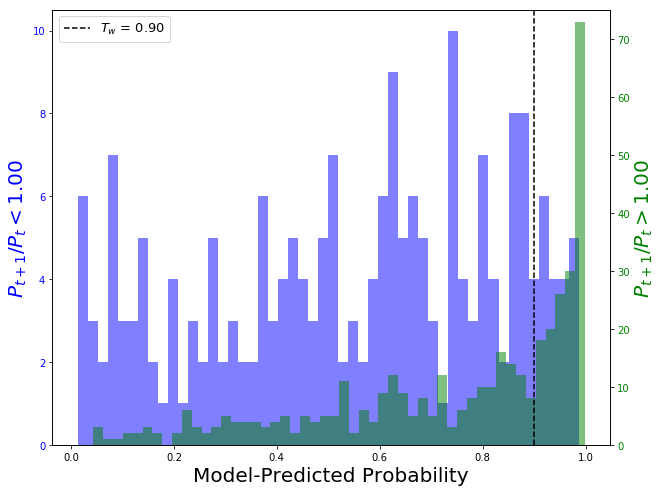

In [13]:
# Histogram to see class predictions
bins = 50
y_pred=xgb_model.predict_proba(X_test)
True_Class=y_pred[y_test==1][:,1]
False_Class=y_pred[y_test==0][:,1]
thresh = 0.9

fig, ax1 = plt.subplots(figsize=(10,8))
ax1.hist(False_Class, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Model-Predicted Probability', fontsize=20)
ax1.set_ylabel('$P_{t+1}/P_t<%.2f$'%true_threshold,  fontsize=20, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(True_Class, bins, alpha=0.5, color='green')
ax2.set_ylabel('$P_{t+1}/P_t>%.2f$'%true_threshold, fontsize=20, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
ax2.set_ylim([0,75])
ax2.plot([thresh,thresh],[0,80],'k--', label=r'$T_w$ = %.2f'%thresh)
plt.legend(fontsize=13)

Tp = float(len(True_Class[True_Class >= thresh]))
Fp = len(False_Class[False_Class >= thresh])
Fn = len(True_Class[True_Class < thresh])
print("Precision=%f, Recall=%f, N_cases=%f"%(Tp/(Tp+Fp), Tp/(Tp+Fn), Tp))

plt.savefig('imgs/results.png')

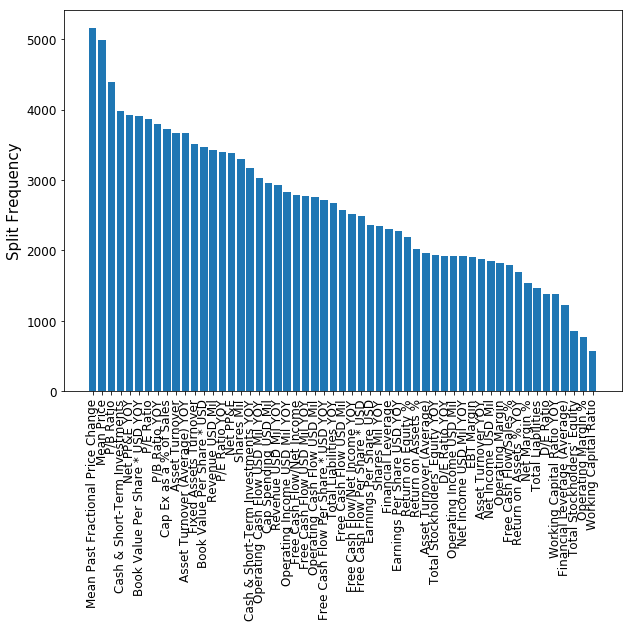

In [16]:
# plot feature importances by fscore
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)[0:20]
plt.figure(figsize=(10,10))
plt.bar(range(len(feat_imp)),feat_imp, tick_label=feat_imp.keys())
plt.xticks(fontsize=12,rotation=90);
plt.yticks(fontsize=12)
plt.gcf().subplots_adjust(bottom=0.35)
plt.ylabel('Split Frequency', fontsize = 15)
plt.savefig('imgs/feature_importances_20.png')

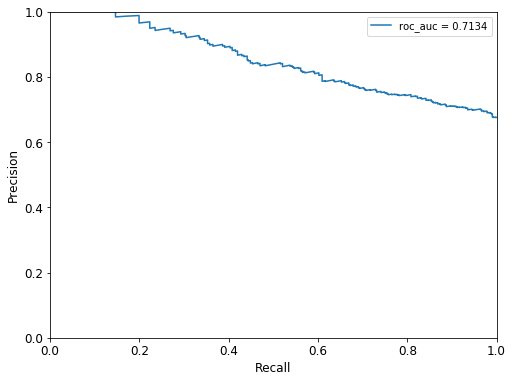

In [46]:
#PR curve
from sklearn.metrics import precision_recall_curve
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='roc_auc = 0.7134')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Recall',fontsize=12)
plt.ylabel('Precision',fontsize=12)
plt.legend()
plt.savefig('imgs/precision_recall.png')

### Helpful links in making this notebook:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  
https://www.boxcontrol.net/write-simple-currency-converter-in-python.html  